Notebook for model runs and data comparisons.

Data is from PSF/ONC.

In [1]:
import sys
sys.path.append('/data/nsoontie/MEOPAR/mixing-paper/analysis')

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as md
from itertools import cycle
import collections
import pandas as pd
import seaborn as sns

from salishsea_tools import tidetools, nc_tools, teos_tools

import ONC_patrols as onc
import mixing

%matplotlib inline

In [2]:
sns.set_context('paper')
sns.set_palette(sns.hls_palette(6, l=.3, s=.8))
sns.set_style('whitegrid')
sns.set_color_codes()

# Load mesh and grid

In [3]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

tmask = mesh_mask.variables['tmask'][:]

gdept = mesh_mask.variables['gdept'][0,:,:,:]
gdepw = mesh_mask.variables['gdepw'][0,:,:,:]

e3t = mesh_mask.variables['e3t'][0,:,:,:]
e3w = mesh_mask.variables['e3w'][0,:,:,:]

thalweg_points, gdept_thal, xx = mixing.load_thalweg(gdept, lons, lats)
_, gdepw_thal, _ = mixing.load_thalweg(gdepw, lons, lats)

# Load Files

In [4]:
start=datetime.datetime(2015,7,9)
end=datetime.datetime(2015,8,17)
home_dir = '/ocean/nsoontie/MEOPAR/SalishSea/results/other_mixing/'

In [5]:
runs = ['base_jul', 'holl_jul', 'enst', 'biharm_5e6', 'biharm_1e6']
labels = {'base_jul': 'Base',
          'background_eddy': 'Back. eddy',
          'base_jul_10s':  '$k-\epsilon 10s$',
          'horizontal': 'Hori.',
          'kw':  '$k-\omega$',
          'holl_jul': 'Holl. corr.',
          'new_bcs':  'BCs',
          'enst': 'enst',
          'mixed': 'mixed',
          'biharm_1e6': 'biharm_1e6',
          'biharm_5e6': 'biharm_5e6'}

In [6]:
grid_t=collections.OrderedDict({})
grid_w=collections.OrderedDict({})
for run in runs:
    grid_t[run] = mixing.results_dataset('1d',start,end,'grid_T',home_dir,run)
    grid_w[run] = mixing.results_dataset('1d',start,end,'grid_W',home_dir,run)
times = mixing.load_time(grid_t[run])

# Plotting

In [7]:
def compare_averages_in_depth(region, start, end, dranges, variables, home_dir, lons, lats, tmask, gdept, axs,
                              labels):
    count=0  
    data = mixing.load_obs_region(region, start, end, composite=False)
    for run in runs:
        model_obs_data = mixing.compile_regional_model_casts(region, data, run, home_dir, 
                                                         lons, lats, 1-tmask, gdept )
        avg_depth, depth_data, std_data = mixing.compile_depth_ranges(dranges, model_obs_data )    
        if count==0:
            diff_sal = pd.DataFrame(index=avg_depth)
            diff_temp = pd.DataFrame(index=avg_depth)
        for variable, ax in zip(variables, axs):
            if variable=='vosaline':
                avg_model = teos_tools.psu_teos(np.array(depth_data['Model Salinity (psu)']))
                avg_obs = teos_tools.psu_teos(np.array(depth_data['Observed Salinity (psu)']))
                ax.set_xlabel('Salinity [g/kg]')
                diff_sal[run] = avg_model-avg_obs
                obs_errorbar = np.array(std_data['Observed Salinity (psu)'][:])
                mod_errorbar = np.array(std_data['Model Salinity (psu)'][:])
            elif variable == 'votemper':
                avg_model = np.array(depth_data['Model Temperature (C)'])
                avg_obs = np.array(depth_data['Observed Temperature (C)'])
                ax.set_xlabel('Temperature [deg C]')
                diff_temp[run] = avg_model-avg_obs
                obs_errorbar = np.array(std_data['Observed Temperature (C)'][:])
                mod_errorbar = np.array(std_data['Model Temperature (C)'][:])
            if count==0:
                ax.errorbar(avg_obs, avg_depth, xerr=obs_errorbar,fmt='o-', label= 'Obs', color='k', capthick=1,ms=5)
            ax.errorbar(avg_model, avg_depth, xerr=mod_errorbar, fmt='o-', label= labels[run], capthick=1,ms=5) 
        count=count+1
    for ax in axs:
        ax.set_ylim([150,0])
        ax.set_ylabel('Depth [m]')
        #ax.set_title(region)
    
    return diff_sal, diff_temp

/data/nsoontie/MEOPAR/mixing-paper/analysis/ONC_patrols.py:130: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  data = data.convert_objects(convert_numeric=True)


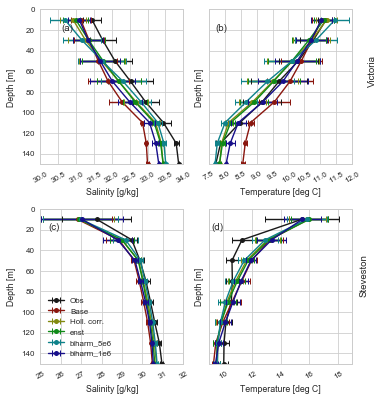

In [8]:
# only August data
start = start=datetime.datetime(2015,8,1)

# depth bins
d1s = np.arange(0,160,20)
d2s = np.arange(20,180,20)
dranges = [(d1,d2) for d1,d2 in zip(d1s,d2s)]

variables = ['vosaline', 'votemper']
fig_comp, axs_comp = plt.subplots(2,2,figsize=(5,5.5), sharey=True)
axs_vic = [axs_comp[0,0], axs_comp[0,1]]
axs_stv = [axs_comp[1,0], axs_comp[1,1]]


region = 'Victoria'
Vic_sal, Vic_temp = compare_averages_in_depth(region, start, end, dranges, variables, home_dir, lons, 
                                              lats, tmask, gdept, axs_vic, labels)
region = 'Steveston'
Stv_sal, Stv_tmep = compare_averages_in_depth(region, start, end, dranges, variables, home_dir, lons,
                                              lats, tmask, gdept, axs_stv, labels)


axs_comp[1,0].legend(loc=0)
ls = ['(a)', '(b)','(c)','(d)']
xs = [30.6, 7.7, 25.4, 9.2]
for ax, l ,x, in zip (axs_comp[:].flatten(), ls, xs):
    ax.text(x, 20, l)
axs_comp[0,1].text(12.5,50,'Victoria',rotation=90)
axs_comp[1,1].text(19.5,50,'Steveston',rotation=90)
for ax in axs_comp[:].flatten():
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=30 )
plt.tight_layout(pad=0.4, h_pad=.8)

In [9]:
Vic_sal.mean()

base_jul     -0.591968
holl_jul     -0.381121
enst         -0.365087
biharm_5e6   -0.362201
biharm_1e6   -0.455062
dtype: float64

In [10]:
Vic_temp.mean()

base_jul      0.324808
holl_jul     -0.113352
enst         -0.117626
biharm_5e6   -0.161585
biharm_1e6    0.058098
dtype: float64

In [11]:
Stv_sal.mean()

base_jul     -0.469837
holl_jul     -0.293500
enst         -0.329104
biharm_5e6   -0.214572
biharm_1e6   -0.401557
dtype: float64

In [12]:
Stv_tmep.mean()

base_jul      0.369259
holl_jul      0.236692
enst          0.291542
biharm_5e6    0.147576
biharm_1e6    0.397223
dtype: float64

Compared to Hollingsworth correction, mixed and enst are a little bit worse in SoG intermeditate, but a little bit better in Victoria. 

The improvement in Victoria comes mostly from the surface. 